# PROJET IA for HumanForYou - Prétraitement des Données

|Auteur|
|---|
|G. DUBOYS DE LAVIGERIE|
|T. VILLETTE|
|O. BOUSSARD|
|A. BRICON|

## Objectifs du Livrable

Ce notebook vise à prétraiter les différentes sources de données fournies par HumanForYou. Les principales étapes comprennent :

1. **Nettoyage des données :** Élimination des valeurs manquantes, correction d'erreurs potentielles.
2. **Transformation des données :** Préparation des données pour l'analyse et la modélisation.
3. **Création de nouvelles caractéristiques :** Le cas échéant, créer de nouvelles caractéristiques basées sur les données existantes.

## Attendus

À la fin de ce notebook, les données seront prêtes à être explorées et utilisées pour l'analyse et le développement du modèle d'IA.

## Prérequis

Avant d'exécuter ce notebook, assurez-vous d'avoir exécuté le notebook `setup.ipynb` pour garantir que la configuration de l'environnement

### Préparation de l'environnement

Ci-dessous quelques imports et précautions préalables à notre travail.

In [29]:
# Compatibilité python 2 et python 3
from __future__ import division, print_function, unicode_literals

# Import de Numpy
import numpy as np

# Stabilité du notebook d'une exécution à l'autre
np.random.seed(42)

# Paramétrer le rendu des figures affichées dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignorer les warnings inutiles
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Import des données

Dans cette section, nous automatisons le processus d'importation des données en implémentant une fonction qui effectue les étapes suivantes :
1. Téléchargement de l'archive contenant les fichiers.
2. Extraction des fichiers de l'archive.

Le code ci-dessous réalise le chargement des fichiers suivants :
- `employee_survey_data.csv`
- `general_data.csv`
- `in_time.csv`
- `out_time.csv`
- `manager_survey_data.csv`

De même, on va créer une fonction utilisant [`pandas`](https://pandas.pydata.org/) qui charge les données en mémoire dans un [`Pandas DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame).

In [30]:
# Imports
import os
import zipfile
from six.moves import urllib
import pandas as pd
import glob

pd.set_option('display.max_columns', None)  # Retirer la limite de colonnes à afficher

# Path
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/"
REPO_PATH = "AnatholyB1/AI_A4/main/"
DATA_PATH = os.path.join("../datasets", "all")
DATA_URL = DOWNLOAD_ROOT + REPO_PATH + "data.zip"

# Récupérer et extraire les fichiers de données
def fetch_data(data_url=DATA_URL, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, "data.zip")
    urllib.request.urlretrieve(data_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_path)

fetch_data()

def load_all_csv(data_path):
    # Trouver tous les fichiers .csv dans data_path et ses sous-répertoires
    csv_files = glob.glob(os.path.join(data_path, '**/*.csv'), recursive=True)
    
    # Charger tous les fichiers .csv
    data = {}
    for file in csv_files:
        # Utiliser le nom de base du fichier (sans l'extension) comme clé
        key = os.path.splitext(os.path.basename(file))[0]
        data[key] = pd.read_csv(file)
    
    return data

data = load_all_csv(DATA_PATH)
#print all the data names
print(data.keys())

dict_keys(['employee_survey_data', 'general_data', 'in_time', 'out_time', 'manager_survey_data'])


### Exploration et prétraitement des fichiers de données

Au sein de cette section, nous effectuons une analyse des fichiers de données dans le but de comprendre en détail leur composition. Des ajustements et transformations sont ensuite appliqués de manière rigoureuse, dans le but optimal de préparer ces données en vue de les adapter au modèle envisagé.


#### Fichier : `general_data.csv`
##### Analyse des données

Afin d'analyser les données, nous allons tout d'abord afficher les différentes informations en utilisant la méthode `.info()` de la bibliothèque Pandas. Cette méthode nous permettra de :

- Visualiser les types de données présents dans chaque colonne.
- Identifier les valeurs manquantes éventuelles.
- Obtenir le nombre total d'entrées dans le jeu de données.


In [31]:
data['general_data'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Concernant les données du fichier `general_data.csv` :

- Nous constatons que les colonnes "*NumCompaniesWorked*" et "*TotalWorkingYears*" comportent des valeurs manquantes.

- De plus, il est important de noter que huit colonnes ne renferment pas de valeurs numériques.

Ces observations soulignent la nécessité d'appliquer une gestion adéquate des valeurs manquantes et éventuellement de convertir les données non numériques. 

Suite à cela, pour analyser les données, nous avons utilisé la méthode `.value_counts()` afin d'identifier, parmi les colonnes non quantitatives, le nombre de valeurs uniques pour chaque colonne. Cette approche nous permet de déduire si ces colonnes sont de nature ordinale ou nominale, apportant ainsi une compréhension approfondie de la structure des données et facilitant la prise de décisions quant aux étapes ultérieures de traitement.


In [32]:
data['general_data']['Department'].value_counts()

Department
Research & Development    2883
Sales                     1338
Human Resources            189
Name: count, dtype: int64

Ainsi, pour une meilleure compréhension des données, nous avons effectué un affichage en histogramme pour chacun des fichiers afin d'observer les distributions des valeurs. D'après ces histogrammes, nos données ne semblent pas contenir de valeurs aberrantes.

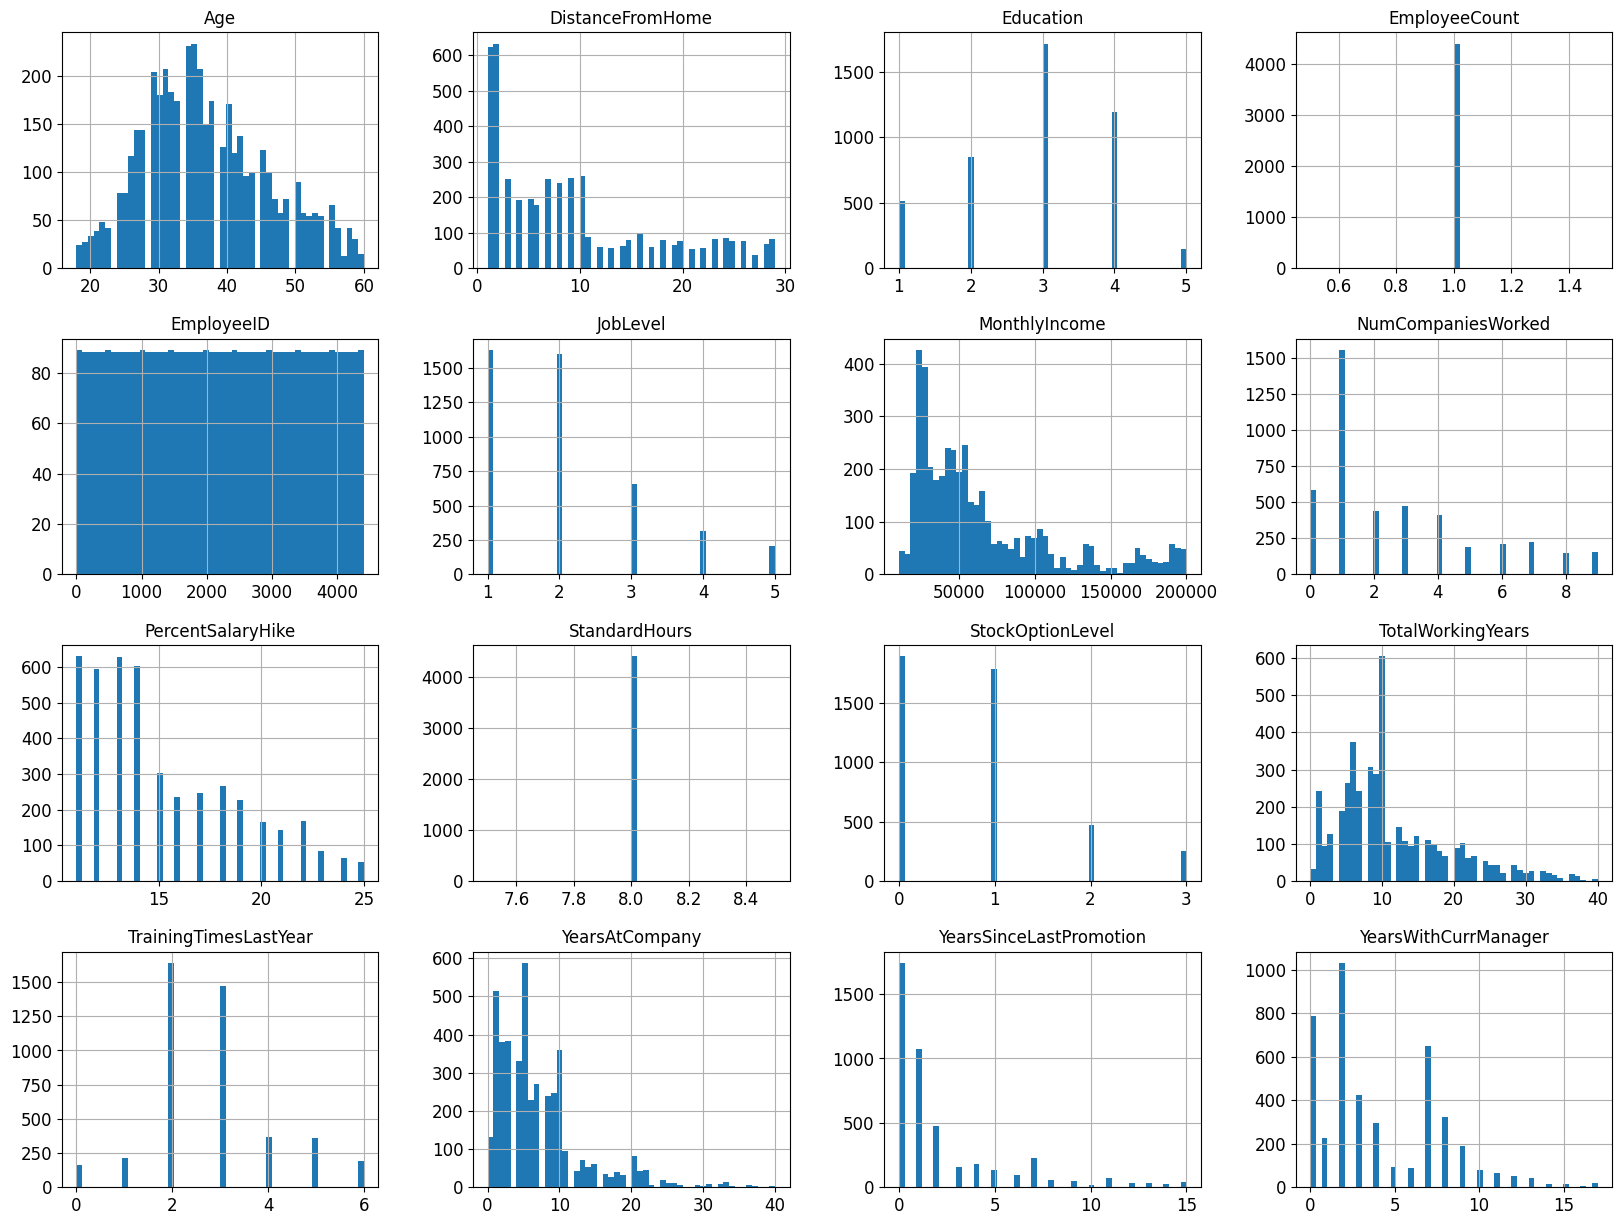

In [33]:
data['general_data'].hist(bins=50, figsize=(20,15))
plt.show()


Voici un tableau résumant toutes les informations :

| **Variable**           | **Type de données** | **Nombre de valeurs Manquantes** | **Nature de la variable** | **Nombre de catégories uniques** |
|------------------------|---------------------|----------------------------------|---------------------------|----------------------------------|
| **Age**                | Quantitative        | 0                                | Ordinal                   | 35                               |
| **Attrition**          | Qualitative         | 0                                | Nominal (Booléen)         | 2                                |
| **BusinessTravel**     | Qualitative         | 0                                | Ordinal                   | 3                                |
| **Department**         | Qualitative         | 0                                | Nominal                   | 3                                |
| **DistanceFromHome**   | Quantitative        | 0                                | Ordinal                   | 16                               |
| **Education**          | Quantitative        | 0                                | Ordinal                   | 5                                |
| **EducationField**     | Qualitative         | 0                                | Nominal                   | 6                                |
| **EmployeeCount**      | Quantitative        | 0                                | Ordinal                   | 1                                |
| **EmployeeID**         | Quantitative        | 0                                | Ordinal                   | 4410                             |
| **Gender**             | Qualitative         | 0                                | Nominal (Booléen)         | 2                                |
| **JobLevel**           | Quantitative        | 0                                | Ordinal                   | 5                                |
| **JobRole**            | Qualitative         | 0                                | Nominal                   | 9                                |
| **MaritalStatus**      | Qualitative         | 0                                | Nominal                   | 3                                |
| **MonthlyIncome**      | Quantitative        | 0                                | Ordinal                   | 1349                             |
| **NumCompaniesWorked** | Quantitative        | 19                               | Ordinal                   | 10                               |
| **Over18**             | Qualitative         | 0                                | Nominal                   | 1                                |
| **PercentSalaryHike**  | Quantitative        | 0                                | Ordinal                   | 14                               |
| **StandardHours**      | Quantitative        | 0                                | Ordinal                   | 1                                |
| **StockOptionLevel**   | Quantitative        | 0                                | Ordinal                   | 4                                |
| **TotalWorkingYears**  | Quantitative        | 9                                | Ordinal                   | 29                               |
| **TrainingTimesLastYear** | Quantitative      | 0                                | Ordinal                   | 7                                |
| **YearsAtCompany**     | Quantitative        | 0                                | Ordinal                   | 29                               |
| **YearsSinceLastPromotion** | Quantitative    | 0                                | Ordinal                   | 15                               |
| **YearsWithCurrManager** | Quantitative      | 0                                | Ordinal                   | 16                               |


##### Préparation des données

L'analyse de ces données nous guide dans les modifications à apporter au jeu de données afin de le préparer au mieux pour le modèle de machine learning.

Tout d'abord, nous supprimons les colonnes inutiles telles que "Over18", "EmployeeCount" et "StandardHours" car leur valeur est constante et n'influe donc pas sur le taux de rotation des employés. De plus, nous supprimons les colonnes discriminantes : "Age", "Gender" et "MaritalStatus". (Voir Livrable Éthique)

Ensuite, nous mettons en place un pipeline pour nettoyer et transformer les données. Ce pipeline se compose de deux étapes :
- **Remplacer les valeurs nulles :**
  Chaque valeur manquante est remplacée par la médiane de la colonne. Les valeurs ordinales sont numérisées à l'aide de la fonction SimpleImputer de scikit-learn.
  
- **Numériser les données qualitatives :**
  Pour les valeurs qualitatives ordinales, nous utilisons l'OrdinalEncoder.
  Pour les valeurs qualitatives nominales, nous faisons appel au OneHotEncoder. Cela génère une colonne booléenne pour chaque catégorie. Par exemple, la colonne "Department" sera décomposée en trois colonnes : "Research & Development", "Sales" et "Human Resources".


In [34]:
# Supprimer les colonnes inutiles et discriminantes
general_dr = data['general_data'].drop(['Over18', 'EmployeeCount', 'StandardHours','Age','Gender','MaritalStatus'], axis=1)

# Préparer le pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

general_num = general_dr.select_dtypes(include=[np.number]) # DataFrame uniquement avec les valeurs numériques
num_attribs = list(general_num) # Récupérer les noms des colonnes numériques

general_cat_ordinal = ['BusinessTravel', 'Attrition'] # Colonnes qualitatives avec des valeurs ordinales
general_cat_nominal = ['Department','EducationField','JobRole'] # Colonnes qualitatives avec des valeurs nominales

# Pipeline numérique
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Remplacer les valeurs nulles par ma médiane des valeurs de la colonne
])

# Pipeline complet
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat_nom", OneHotEncoder(drop='if_binary'), general_cat_nominal), # Numériser les colonnes qualitatives avec des valeurs nominales
    ("cat_ord", OrdinalEncoder(), general_cat_ordinal), # Numériser les colonnes qualitatives avec des valeurs ordinales
])

# Appliquer le pipeline au DataFrame initial
general_tr = full_pipeline.fit_transform(general_dr)

# Créer un DataFrame à partir du résultat
general_prepared = pd.DataFrame(general_tr, columns=num_attribs + list(full_pipeline.named_transformers_['cat_nom'].get_feature_names_out()) + general_cat_ordinal)
general_prepared.head()


,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel,Attrition
0,6.0,2.0,1.0,1.0,131160.0,1.0,11.0,0.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,10.0,1.0,2.0,1.0,41890.0,0.0,23.0,1.0,6.0,3.0,5.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,17.0,4.0,3.0,4.0,193280.0,1.0,15.0,3.0,5.0,2.0,5.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2.0,5.0,4.0,3.0,83210.0,3.0,11.0,3.0,13.0,5.0,8.0,7.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.0,1.0,5.0,1.0,23420.0,4.0,12.0,2.0,9.0,2.0,6.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0


Nous pouvons désormais constater qu'après transformation, toutes nos données sont numériques et qu'il n'y a plus de valeurs nulles. Nous allons suivre la même procédure pour les trois autres fichiers.


#### Fichier : `employee_survey_data.csv`

Nous analysons et préparons les données du fichier `employee_survey_data.csv` en utilisant la même méthode que dans la partie précédente. Nous avons observé la présence de quelques valeurs manquantes dans une colonne.

La seule transformation appliquée dans ce fichier est le remplacement des valeurs nulles par la médiane. Voici le pipeline :

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Créer un pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])


# Appliquer le pipeline à l'ensemble du DataFrame
employee_transformed = numeric_transformer.fit_transform(data['employee_survey_data'])

# Transformer le résultat du pipeline en DataFrame
employee_df = pd.DataFrame(employee_transformed, columns = data['employee_survey_data'].columns)
employee_df.head()


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1.0,3.0,4.0,2.0
1,2.0,3.0,2.0,4.0
2,3.0,2.0,2.0,1.0
3,4.0,4.0,4.0,3.0
4,5.0,4.0,1.0,3.0


#### Fichier : `in_time.csv` et `out_time.csv`

Pour les fichiers `in_time.csv` et `out_time.csv`, toutes les valeurs sont converties en format DateTime, car elles sont plus simples à manipuler. Voici le code associé :

In [36]:
# Convertir toutes les valeurs en DateTime
def convert_all_to_datetime(df):
    year_dict = {}
    month_dict = {}
    day_dict = {}

    for column_name in df.columns:
        try:
            df[column_name] = pd.to_datetime(df[column_name])
            year_dict[column_name + '-year'] = df[column_name].dt.year
            month_dict[column_name + '-month'] = df[column_name].dt.month
            day_dict[column_name + '-day'] = df[column_name].dt.day
        except ValueError:
            # Passe les valeurs qui ne peuvent pas être converties en DateTime
            pass

    year_df = pd.DataFrame(year_dict)
    month_df = pd.DataFrame(month_dict)
    day_df = pd.DataFrame(day_dict)

    df = pd.concat([df, year_df, month_df, day_df], axis=1)
    return df

# Convertir en DateTime toutes les valeurs des fichiers Out_time et In_time
in_time = convert_all_to_datetime(data['in_time'])
out_time = convert_all_to_datetime(data['out_time'])

Ensuite, nous utilisons un pipeline pour préparer les données au modèle de machine learning. Les actions du pipeline sont les suivantes :

1. **Suppression des colonnes non liées aux dates :**
   - Les colonnes qui ne représentent pas des dates sont supprimées, simplifiant ainsi le traitement ultérieur.

2. **Remplacement des valeurs nulles :**
   - Lorsqu'une valeur est manquante dans un fichier, elle peut être calculée grâce à la valeur correspondante dans l'autre fichier. Si les deux valeurs correspondantes sont nulles dans les deux fichiers, la ligne est supprimée.

3. **Transformation des données :**
   - Toutes les données sont transformées pour ne conserver que la médiane des heures travaillées par employé. Cette étape facilite le traitement ultérieur, car ces valeurs agrégées sont plus simples à manipuler que des DateTime sur toute une année. Cette approche vise à simplifier les données en les condensant autour de mesures statistiques fondamentales, ce qui facilite le traitement et l'analyse dans le contexte du modèle de machine learning.

4. **Ajout de l'Employee_ID :**
   - L'Employee_ID est ajouté pour permettre la liaison avec les autres fichiers de données.




In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
 
# Calcule les valeurs manquantes et supprime les colonnes qui ne sont pas des dates
def clean_datetime(X,  Y):    
    cols_to_drop = X.filter(regex='-day$').columns
    X = X.drop(cols_to_drop, axis=1)
    cols_to_drop = X.filter(regex='-month$').columns
    X = X.drop(cols_to_drop, axis=1)
    cols_to_drop = X.filter(regex='-year$').columns
    X = X.drop(cols_to_drop, axis=1)


    first_column = X.columns[0]
    X = X.drop([first_column], axis=1)
    # Supprimer les colonnes où toutes les valeurs sont NaT
    X = X.dropna(axis=1, how='all')

    cols_to_drop = Y.filter(regex='-day$').columns
    Y = Y.drop(cols_to_drop, axis=1)
    cols_to_drop = Y.filter(regex='-month$').columns
    Y = Y.drop(cols_to_drop, axis=1)
    cols_to_drop = Y.filter(regex='-year$').columns
    Y = Y.drop(cols_to_drop, axis=1)


    first_column = Y.columns[0]
    Y = Y.drop([first_column], axis=1)

    # Supprimer les colonnes où toutes les valeurs sont NaT
    Y = Y.dropna(axis=1, how='all')


    # Calculer la médiane du temps horaire pour chaque personne
    median_time = (Y - X).median()

    for column in X.columns:
        # Trouver où les valeurs sont manquantes
        in_time_nan = X[column].isna()
        out_time_nan = Y[column].isna()

        # Si 'in_time' est manquant, soustraire la médiane du temps horaire à 'out_time'
        X.loc[in_time_nan, column] = X.loc[in_time_nan, column] - median_time[column]

        # Si 'out_time' est manquant, ajouter la médiane du temps horaire à 'in_time'
        Y.loc[out_time_nan, column] = Y.loc[out_time_nan, column] + median_time[column]
    
    return  Y - X


# Transformer les données pour ne garder que la moyenne, le médian, le minimum et le maximum
class PreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy="median")

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        for col in X.columns:
            X[col] = X[col].apply(lambda x: x.total_seconds() / 3600 if pd.notnull(x) else np.nan)    
        stats = pd.DataFrame()
        stats['MedianWorkingTime'] = pd.Series(X.median(axis=1))  # Only keeping the median
        return stats, ['MedianWorkingTime']  # Return only the median and rename the column
        # Convertir les timedelta en une quantité numérique représentant le nombre d'heures


# Définir le pipeline
num_pipeline = Pipeline([
    ('pre_transformer', PreTransformer()),
])

# Appliquer le pipeline
hourly_time_prepared, stats_col = num_pipeline.fit_transform(clean_datetime(in_time, out_time))

hourly_time_prepared = pd.DataFrame(hourly_time_prepared, columns= stats_col )

#Ajouter la colonne 'EmployeeID' pour pouvoir joindre les DataFrames
hourly_time_prepared['EmployeeID'] = employee_df['EmployeeID']


Voici un aperçu des données après ces transformations :

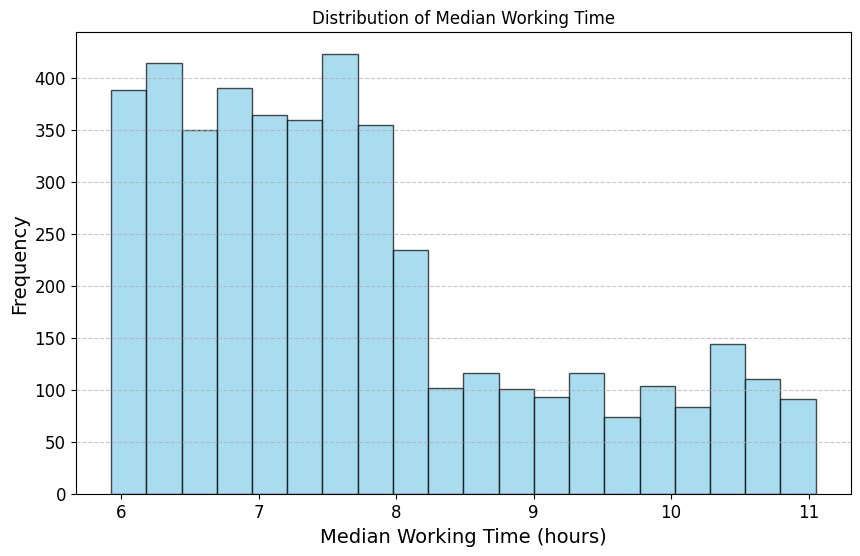

,MedianWorkingTime,EmployeeID
0,7.397222,1.0
1,7.718750,2.0
2,6.982639,3.0
3,7.179722,4.0
4,7.963611,5.0


In [38]:
# Visualize the median working time distribution
plt.figure(figsize=(10, 6))
plt.hist(hourly_time_prepared['MedianWorkingTime'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Median Working Time')
plt.xlabel('Median Working Time (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

hourly_time_prepared.head()

### Jointure et préparation finale des données

Maintenant que chaque donnée présente dans chacun des fichiers a été explorée et qu'un prétraitement a été effectué, il est nécessaire de rassembler toutes ces données en un seul fichier qui sera utilisé ultérieurement par notre modèle.

#### Fusion des données

Après avoir nettoyé les fichiers de données individuellement, nous procéderons à une jointure sur l'ID employé présent dans tous les fichiers, afin de former un seul jeu de données consolidé.


In [39]:
# Utiliser la fonction merge pour faire la première jointure avec general
result = pd.merge(employee_df, data['manager_survey_data'], on='EmployeeID')

# Utiliser la fonction merge pour faire la deuxième jointure avec general_prepared
result = pd.merge(result, general_prepared, left_on='EmployeeID', right_on='EmployeeID')

# Utiliser la fonction merge pour faire la troisieme jointure avec hourly_time_prepared
result = pd.merge(result, hourly_time_prepared, on='EmployeeID')

# Aperçu des données
result.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel,Attrition,MedianWorkingTime
0,1.0,3.0,4.0,2.0,3,3,6.0,2.0,1.0,131160.0,1.0,11.0,0.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.397222
1,2.0,3.0,2.0,4.0,2,4,10.0,1.0,1.0,41890.0,0.0,23.0,1.0,6.0,3.0,5.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7.718750
2,3.0,2.0,2.0,1.0,3,3,17.0,4.0,4.0,193280.0,1.0,15.0,3.0,5.0,2.0,5.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.982639
3,4.0,4.0,4.0,3.0,2,3,2.0,5.0,3.0,83210.0,3.0,11.0,3.0,13.0,5.0,8.0,7.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.179722
4,5.0,4.0,1.0,3.0,3,3,10.0,1.0,1.0,23420.0,4.0,12.0,2.0,9.0,2.0,6.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,7.963611


#### Préparation des données

Pour préparer le jeu de données au modèle de machine learning, nous appliquons les dernières transformations. Tout d'abord, les colonnes Employee_ID qui ne sont plus utiles sont supprimées.

Ensuite, une standardisation des données est appliquée afin de réduire les différences d'échelle des valeurs, assurant ainsi un poids équivalent sur toutes les colonnes. Nous avons opté pour une standardisation plutôt qu'une normalisation min-max, car elle préserve la structure originale des données.

Enfin, notre jeu de données est enregistré dans un nouveau fichier CSV nommé `data_preprocessing.csv`, qui sera utilisé par la suite dans le notebook `model_training_evaluation.ipynb`.

In [40]:
# Supprimer les colonnes Employee_ID
result_dr = result.drop(['EmployeeID'], axis=1)

# Créer un pipeline
result_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Standardiser les données
result_array = result_transformer.fit_transform(result_dr)
result_final = pd.DataFrame(result_array, columns = result_dr.columns)

# Enregistrer les données résultantes dans un nouveau fichier CSV
result_final.to_csv('../datasets/data_preprocessing.csv', index=False)

# Aperçu du jeu de données final
result_final.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel,Attrition,MedianWorkingTime
0,0.252200,1.156302,-1.085336,0.379672,-0.426230,-0.393938,-0.891688,-0.961486,1.405136,-0.678464,-1.150554,-0.932014,-1.322079,2.483396,-0.981014,-0.679146,-1.155935,-0.211604,-1.374051,1.515244,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,3.197088,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,-0.533821,-0.244625,0.590048,-0.438422,-0.226421
1,0.252200,-0.663899,1.757749,-1.026167,2.346151,0.099639,-1.868426,-0.961486,-0.491661,-1.079486,2.129306,0.241988,-0.678877,0.155707,-0.327893,-0.368715,-0.034520,-0.211604,0.727775,-0.659960,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,-0.312785,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,2.008543,-0.533821,-0.244625,-0.913194,2.280906,0.013492
2,-0.665460,-0.663899,-2.506879,0.379672,-0.426230,0.963398,1.061787,1.749610,2.725053,-0.678464,-0.057267,2.589994,-0.807517,-0.620189,-0.327893,-0.679146,-0.314873,-0.211604,0.727775,-0.659960,-0.136788,-0.837490,-0.348255,-0.679141,4.114223,-0.314093,-0.312785,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,1.873287,-0.244625,-0.913194,-0.438422,-0.535768
3,1.169861,1.156302,0.336206,-1.026167,-0.426230,-0.887515,2.038524,0.845911,0.386301,0.123580,-1.150554,2.589994,0.221606,1.707500,0.161947,1.493867,0.245834,-0.211604,0.727775,-0.659960,-0.136788,1.194045,-0.348255,-0.679141,-0.243059,-0.314093,-0.312785,5.221995,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,-0.533821,-0.244625,-2.416437,-0.438422,-0.388711
4,1.169861,-1.573999,0.336206,0.379672,-0.426230,0.099639,-1.868426,-0.961486,-0.884109,0.524602,-0.877232,1.415991,-0.292956,-0.620189,-0.164613,-0.679146,-0.034520,-0.211604,0.727775,-0.659960,-0.136788,-0.837490,-0.348255,1.472448,-0.243059,-0.314093,-0.312785,-0.191498,-0.462464,-0.273059,-0.330808,-0.239904,-0.497873,1.873287,-0.244625,0.590048,-0.438422,0.196198


### Corrélation des données

Nous effectuons une analyse de corrélation des données afin de déterminer quelles colonnes ont le plus d'influence sur l'attrition. Cette étape nous permet de comprendre les relations linéaires entre différentes variables et d'identifier les facteurs qui peuvent avoir un impact significatif sur le phénomène de l'attrition.

In [41]:
from sklearn.model_selection import train_test_split

# Supposons que vous voulez prédire 'cat_nom__Attrition_Yes'
y = result['Attrition']
X = result.drop(['Attrition'], axis=1)

# Diviser les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.DataFrame(pd.concat([X_train, y_train], axis = 1), columns=result.columns)


# Calculer la matrice de corrélation
corr_matrix = train_df.corr()
# Filtrer les corrélations
filtered_corr_matrix = corr_matrix.where((corr_matrix >= 0.4) | (corr_matrix <= -0.4))

# Trier la colonne 'cat_nom__Attrition_Yes' par valeur absolue
sorted_corr = corr_matrix['Attrition'].apply(abs).sort_values(ascending=False)

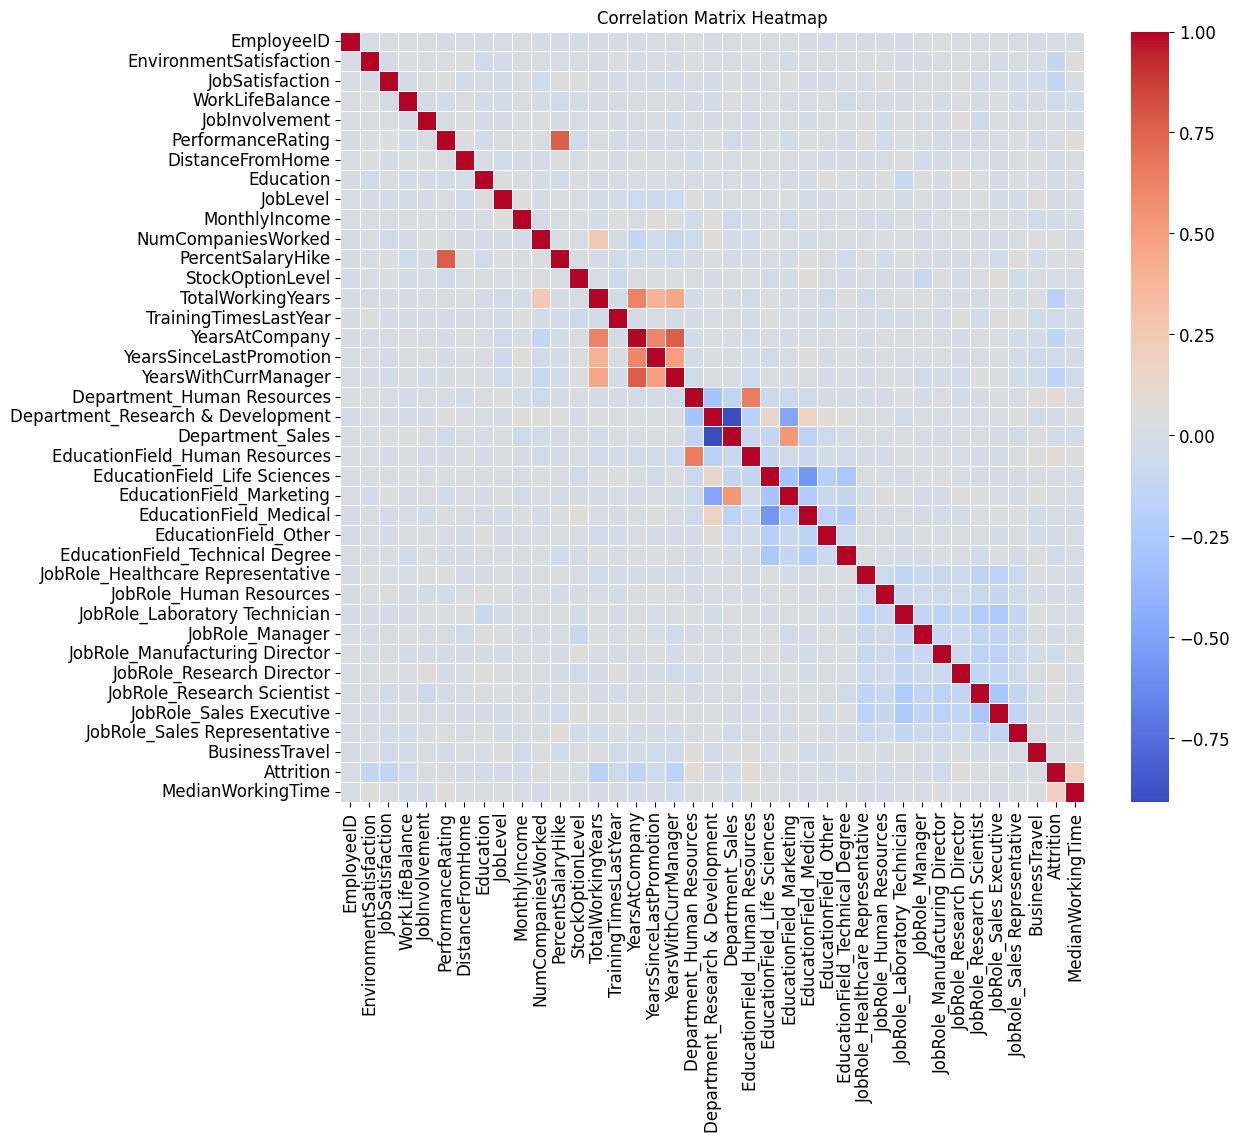

Attrition                            1.000000
MedianWorkingTime                    0.199006
TotalWorkingYears                    0.181715
YearsWithCurrManager                 0.168111
YearsAtCompany                       0.148827
JobSatisfaction                      0.125388
EnvironmentSatisfaction              0.106991
EducationField_Human Resources       0.090365
Department_Human Resources           0.081012
JobRole_Research Director            0.061039
TrainingTimesLastYear                0.055528
WorkLifeBalance                      0.054258
JobRole_Manufacturing Director       0.047874
YearsSinceLastPromotion              0.044533
EducationField_Technical Degree      0.040977
NumCompaniesWorked                   0.033931
JobRole_Research Scientist           0.033305
MonthlyIncome                        0.033218
Department_Sales                     0.027407
EducationField_Other                 0.026256
JobRole_Human Resources              0.025110
JobRole_Sales Representative      

In [42]:
import seaborn as sns

# Calculer la matrice de corrélation
corr_matrix = train_df.corr()

# Créer un heatmap sans les annotations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Afficher les éléments les plus corrélés avec 'cat_nom__Attrition_Yes'
sorted_corr


On constate que certaines colonnes ont une influence plus prononcée sur le taux de rotation des employés. Par exemple, le nombre d'heures de travail, la satisfaction au travail, ainsi que le nombre d'années de travail pour le même type de poste, semblent être des informations cruciales ayant une importance significative dans le phénomène de l'attrition.

### Conclusion

Dans ce livrable, nous avons entrepris une analyse approfondie et un nettoyage des données de chacun des fichiers CSV en traitant les valeurs manquantes et en numérisant les données qualitatives, entre autres. Ensuite, nous avons fusionné ces fichiers en un seul jeu de données, que nous avons standardisé pour le préparer de manière optimale au modèle de machine learning. Enfin, une fois les données prêtes, nous avons procédé à une analyse de corrélation pour identifier les paramètres ayant une influence sur l'attrition des employés.